In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import psycopg2

In [3]:
from sql_functions import get_dataframe
from sql_functions import get_engine

In [4]:
# Floats (decimal numbers) should be displayed rounded with 2 decimal places
pd.options.display.float_format = "{:,.2f}".format
# Set style for plots
plt.style.use('fivethirtyeight') 

In [5]:
schema = 'hh_analytics_24_1'

### Retrieving weather data from DBeaver

In [13]:
schema = 'hh_analytics_24_1'

#sql_query to retrieve the data from DBeaver and saving it as a df
sql_query = f'SELECT * FROM {schema}.weather_snow_2'
weather = get_dataframe(sql_query)

weather

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id,faa
0,2010-02-01,-0.90,-3.90,2.80,0.00,0.00,270.00,22.30,None,"1,023.40",None,74486,JFK
1,2010-02-02,-1.00,-3.90,0.60,0.00,0.00,46.00,10.10,None,"1,023.80",None,74486,JFK
2,2010-02-03,0.30,-2.20,4.40,0.80,25.00,343.00,15.80,None,"1,018.10",None,74486,JFK
3,2010-02-04,0.80,-1.70,3.30,0.00,0.00,317.00,22.30,None,"1,025.80",None,74486,JFK
4,2010-02-05,0.60,-1.70,2.80,0.00,0.00,335.00,11.50,None,"1,023.30",None,74486,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2010-02-24,2.50,1.70,3.90,6.10,0.00,355.00,20.20,None,"1,006.40",None,72503,LGA
164,2010-02-25,0.80,-1.70,1.70,37.80,0.00,338.00,18.40,None,995.20,None,72503,LGA
165,2010-02-26,-0.60,-2.80,1.70,18.00,254.00,306.00,22.30,None,987.20,None,72503,LGA
166,2010-02-27,1.70,-1.10,3.90,0.00,203.00,228.00,13.00,None,999.20,None,72503,LGA


In [14]:
#keeping only those columns, which are intersting for us (as defined in hypothesis)
weather_short = weather[['date', 'tavg', 'tmin', 'tmax', 'snow', 'wspd', 'faa']].copy()

In [15]:
weather_short['date']= pd.to_datetime(weather_short['date'])

In [16]:
weather_short.isna().sum()

date    0
tavg    0
tmin    0
tmax    0
snow    0
wspd    0
faa     0
dtype: int64

In [17]:
weather_short.duplicated().value_counts()

False    168
dtype: int64

In [10]:
#duplicates were checked and then excluded from the dataframe
#weather_short_sf.drop_duplicates(inplace=True)

In [11]:
#weather_short_sf.reset_index(drop=True, inplace=True)

In [18]:
weather_short.rename(columns={'tavg':'average_temp', 'tmin': 'min_temp', 'tmax': 'max_temp', 'wspd': 'windspeed'}, inplace=True)

weather_short.head()

,date,average_temp,min_temp,max_temp,snow,windspeed,faa
0,2010-02-01,-0.90,-3.90,2.80,0.00,22.30,JFK
1,2010-02-02,-1.00,-3.90,0.60,0.00,10.10,JFK
2,2010-02-03,0.30,-2.20,4.40,25.00,15.80,JFK
3,2010-02-04,0.80,-1.70,3.30,0.00,22.30,JFK
4,2010-02-05,0.60,-1.70,2.80,0.00,11.50,JFK


In [19]:
weather_short[['faa']].value_counts()

faa
BWI    28
EWR    28
IAD    28
JFK    28
LGA    28
PHL    28
dtype: int64

### Retrieving Flight Data From DBeaver

In [20]:


schema = 'hh_analytics_24_1'

sql_query = f'SELECT * FROM {schema}.flights_group_x'
flights_x_sf = get_dataframe(sql_query)
flights_x_sf.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,...,air_time,actual_elapsed_time,distance,cancelled,diverted,lat,lon,city,tz_origin,tz_dest
0,2010-02-02,727.00,730,-3.00,835.00,855,-20.00,WN,N798SW,61,...,43.00,68.00,185.00,0,0,40.78,-73.87,New York,-5.00,-5.00
1,2010-02-02,"1,536.00",1540,-4.00,"1,646.00",1710,-24.00,WN,N210WN,65,...,40.00,70.00,185.00,0,0,40.78,-73.87,New York,-5.00,-5.00
2,2010-02-02,"1,239.00",1130,69.00,"1,338.00",1255,43.00,WN,N207WN,2064,...,42.00,59.00,185.00,0,0,40.78,-73.87,New York,-5.00,-5.00
3,2010-02-02,"1,355.00",1355,0.00,"1,514.00",1550,-36.00,WN,N456WN,232,...,111.00,139.00,725.00,0,0,40.78,-73.87,New York,-5.00,-6.00
4,2010-02-02,"1,026.00",1030,-4.00,"1,145.00",1225,-40.00,WN,N227WN,1510,...,116.00,139.00,725.00,0,0,40.78,-73.87,New York,-5.00,-6.00


In [21]:
#keeping only relevant columns

flights_short_sf = flights_x_sf[['flight_date', 'origin', 'dest', 'cancelled']].copy()

In [22]:
flights_short_sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50136 entries, 0 to 50135
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   flight_date  50136 non-null  datetime64[ns]
 1   origin       50136 non-null  object        
 2   dest         50136 non-null  object        
 3   cancelled    50136 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.5+ MB


In [23]:
flights_short_sf.isna().sum()

flight_date    0
origin         0
dest           0
cancelled      0
dtype: int64

In [24]:
flights_short_sf.duplicated().value_counts()

True     38941
False    11195
dtype: int64

In [105]:
duplicated_rows = flights_short_sf[flights_short_sf.duplicated()]
print(duplicated_rows)
#we keep them

      flight_date origin dest  cancelled
1      2010-02-02    LGA  BWI          0
2      2010-02-02    LGA  BWI          0
4      2010-02-02    LGA  MDW          0
5      2010-02-02    LGA  MDW          0
6      2010-02-02    LGA  MDW          0
...           ...    ...  ...        ...
50130  2010-02-01    MDW  LGA          0
50131  2010-02-01    MDW  LGA          0
50132  2010-02-01    MDW  LGA          0
50134  2010-02-02    BWI  LGA          0
50135  2010-02-02    BWI  LGA          0

[38941 rows x 4 columns]


In [25]:
#Left merge was done to keep all origins and dates from the flights data 

merged_df = flights_short_sf.merge(weather_short, how='left', left_on='origin', right_on='faa')

# Display the merged DataFrame
merged_df

,flight_date,origin,dest,cancelled,date,average_temp,min_temp,max_temp,snow,windspeed,faa
0,2010-02-02,LGA,BWI,0,2010-02-01,-0.50,-2.80,2.20,0.00,22.30,LGA
1,2010-02-02,LGA,BWI,0,2010-02-02,-0.30,-1.70,1.10,0.00,10.80,LGA
2,2010-02-02,LGA,BWI,0,2010-02-03,0.40,-2.20,3.30,25.00,16.90,LGA
3,2010-02-02,LGA,BWI,0,2010-02-04,0.80,-1.70,3.30,0.00,22.30,LGA
4,2010-02-02,LGA,BWI,0,2010-02-05,1.00,-0.60,2.80,0.00,11.20,LGA
...,...,...,...,...,...,...,...,...,...,...,...
746515,2010-02-02,BWI,LGA,0,2010-02-24,4.40,1.70,7.20,0.00,9.40,BWI
746516,2010-02-02,BWI,LGA,0,2010-02-25,1.80,-1.70,3.90,0.00,24.50,BWI
746517,2010-02-02,BWI,LGA,0,2010-02-26,-0.20,-2.20,2.20,0.00,37.40,BWI
746518,2010-02-02,BWI,LGA,0,2010-02-27,1.80,-1.70,6.10,0.00,16.60,BWI


In [26]:
# the flight_date and date columns do not match in merged_df
merged_snow = flights_short_sf.merge(weather_short, 
                                   how='left', 
                                   left_on=['origin', 'flight_date'], 
                                   right_on=['faa', 'date'])


In [27]:
merged_snow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50136 entries, 0 to 50135
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   flight_date   50136 non-null  datetime64[ns]
 1   origin        50136 non-null  object        
 2   dest          50136 non-null  object        
 3   cancelled     50136 non-null  int64         
 4   date          25792 non-null  datetime64[ns]
 5   average_temp  25792 non-null  float64       
 6   min_temp      25792 non-null  float64       
 7   max_temp      25792 non-null  float64       
 8   snow          25792 non-null  float64       
 9   windspeed     25792 non-null  float64       
 10  faa           25792 non-null  object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(3)
memory usage: 4.6+ MB


In [28]:
merged_df.faa.unique()

array(['LGA', nan, 'BWI', 'EWR', 'IAD', 'JFK', 'PHL'], dtype=object)

In [29]:
merged_snow.drop(columns=['faa'], inplace=True)

In [30]:
merged_snow.drop(columns=['date'], inplace=True)

In [31]:
weather_flights_x_sf = merged_snow

In [32]:
import pandas as pd

# Define the list of valid origin airports
valid_origins = ['JFK', 'IAD', 'BWI', 'PHL', 'EWR', 'LGA']

# Filter the DataFrame to include only rows with origin in the list of valid origins
weather_flights_x_sf['origin_2'] = weather_flights_x_sf['origin'].where(weather_flights_x_sf['origin'].isin(valid_origins))

# Display the DataFrame with the new variable
print(weather_flights_x_sf.head())


  flight_date origin dest  cancelled  average_temp  min_temp  max_temp  snow  \
0  2010-02-02    LGA  BWI          0         -0.30     -1.70      1.10  0.00   
1  2010-02-02    LGA  BWI          0         -0.30     -1.70      1.10  0.00   
2  2010-02-02    LGA  BWI          0         -0.30     -1.70      1.10  0.00   
3  2010-02-02    LGA  MDW          0         -0.30     -1.70      1.10  0.00   
4  2010-02-02    LGA  MDW          0         -0.30     -1.70      1.10  0.00   

   windspeed origin_2  
0      10.80      LGA  
1      10.80      LGA  
2      10.80      LGA  
3      10.80      LGA  
4      10.80      LGA  


In [33]:
weather_flights_x_sf['origin_2'].value_counts()

JFK    8901
EWR    8724
LGA    7449
IAD     412
BWI     250
PHL      56
Name: origin_2, dtype: int64

In [34]:
weather_flights_x_sf.isna().sum()

flight_date         0
origin              0
dest                0
cancelled           0
average_temp    24344
min_temp        24344
max_temp        24344
snow            24344
windspeed       24344
origin_2        24344
dtype: int64

In [36]:
# Drop rows where 'origin_2' contains NaN values
weather_flights_x_sf.dropna(subset=['average_temp', 'min_temp', 'max_temp', 'snow', 'windspeed', 'origin_2'], inplace=True)

# Display the DataFrame after dropping NaN values
print(weather_flights_x_sf.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25792 entries, 0 to 50135
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   flight_date   25792 non-null  datetime64[ns]
 1   origin        25792 non-null  object        
 2   dest          25792 non-null  object        
 3   cancelled     25792 non-null  int64         
 4   average_temp  25792 non-null  float64       
 5   min_temp      25792 non-null  float64       
 6   max_temp      25792 non-null  float64       
 7   snow          25792 non-null  float64       
 8   windspeed     25792 non-null  float64       
 9   origin_2      25792 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 2.2+ MB
None


### EDA

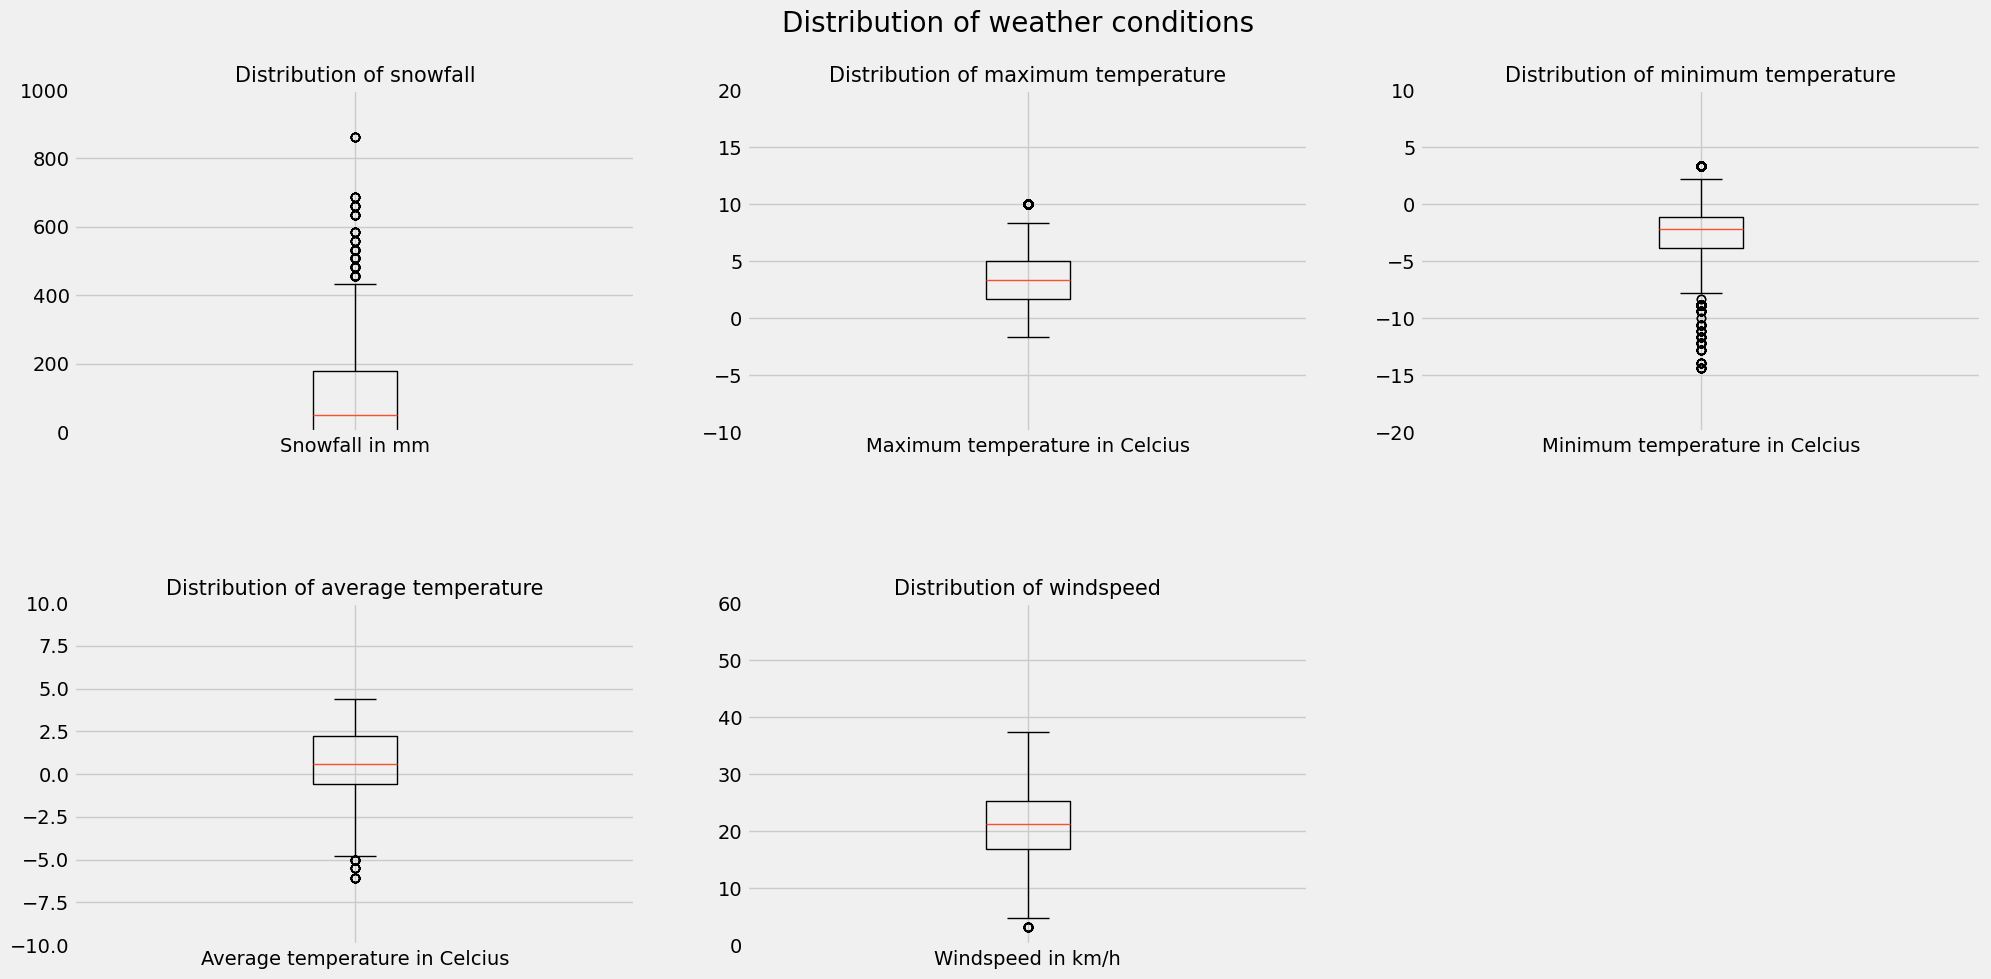

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(20, 10))  # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of weather conditions', fontsize=20)
fig.tight_layout()  # tight_layout automatically adjusts subplot params so that the subplot(s) fits into the figure area
plt.subplots_adjust(hspace=0.5, wspace=0.2, top=0.9)  # adjusts the space between the single subplots

# Boxplot for snowfall
ax[0][0].boxplot(x=weather_flights_x_sf['snow'])
ax[0][0].set_xticklabels(labels=["Snowfall in mm"])
ax[0][0].set_ylim(0, 1000)
ax[0][0].set_title("Distribution of snowfall", fontsize=15)

# Boxplot for maximum temperature
ax[0][1].boxplot(x=weather_flights_x_sf['max_temp'])
ax[0][1].set_xticklabels(labels=["Maximum temperature in Celcius"])
ax[0][1].set_ylim(-10, 20)
ax[0][1].set_title("Distribution of maximum temperature", fontsize=15)

# Boxplot for minimum temperature
ax[0][2].boxplot(x=weather_flights_x_sf['min_temp'])
ax[0][2].set_xticklabels(labels=["Minimum temperature in Celcius"])
ax[0][2].set_ylim(-20, 10)
ax[0][2].set_title("Distribution of minimum temperature", fontsize=15)

# Boxplot for average temperature
ax[1][0].boxplot(x=weather_flights_x_sf['average_temp'])
ax[1][0].set_xticklabels(labels=["Average temperature in Celcius"])
ax[1][0].set_ylim(-10, 10)
ax[1][0].set_title("Distribution of average temperature", fontsize=15)

# Boxplot for windspeed
ax[1][1].boxplot(x=weather_flights_x_sf['windspeed'])
ax[1][1].set_xticklabels(labels=["Windspeed in km/h"])
ax[1][1].set_ylim(0, 60)
ax[1][1].set_title("Distribution of windspeed", fontsize=15)

# Remove the last subplot
fig.delaxes(ax[1][2])

plt.show()


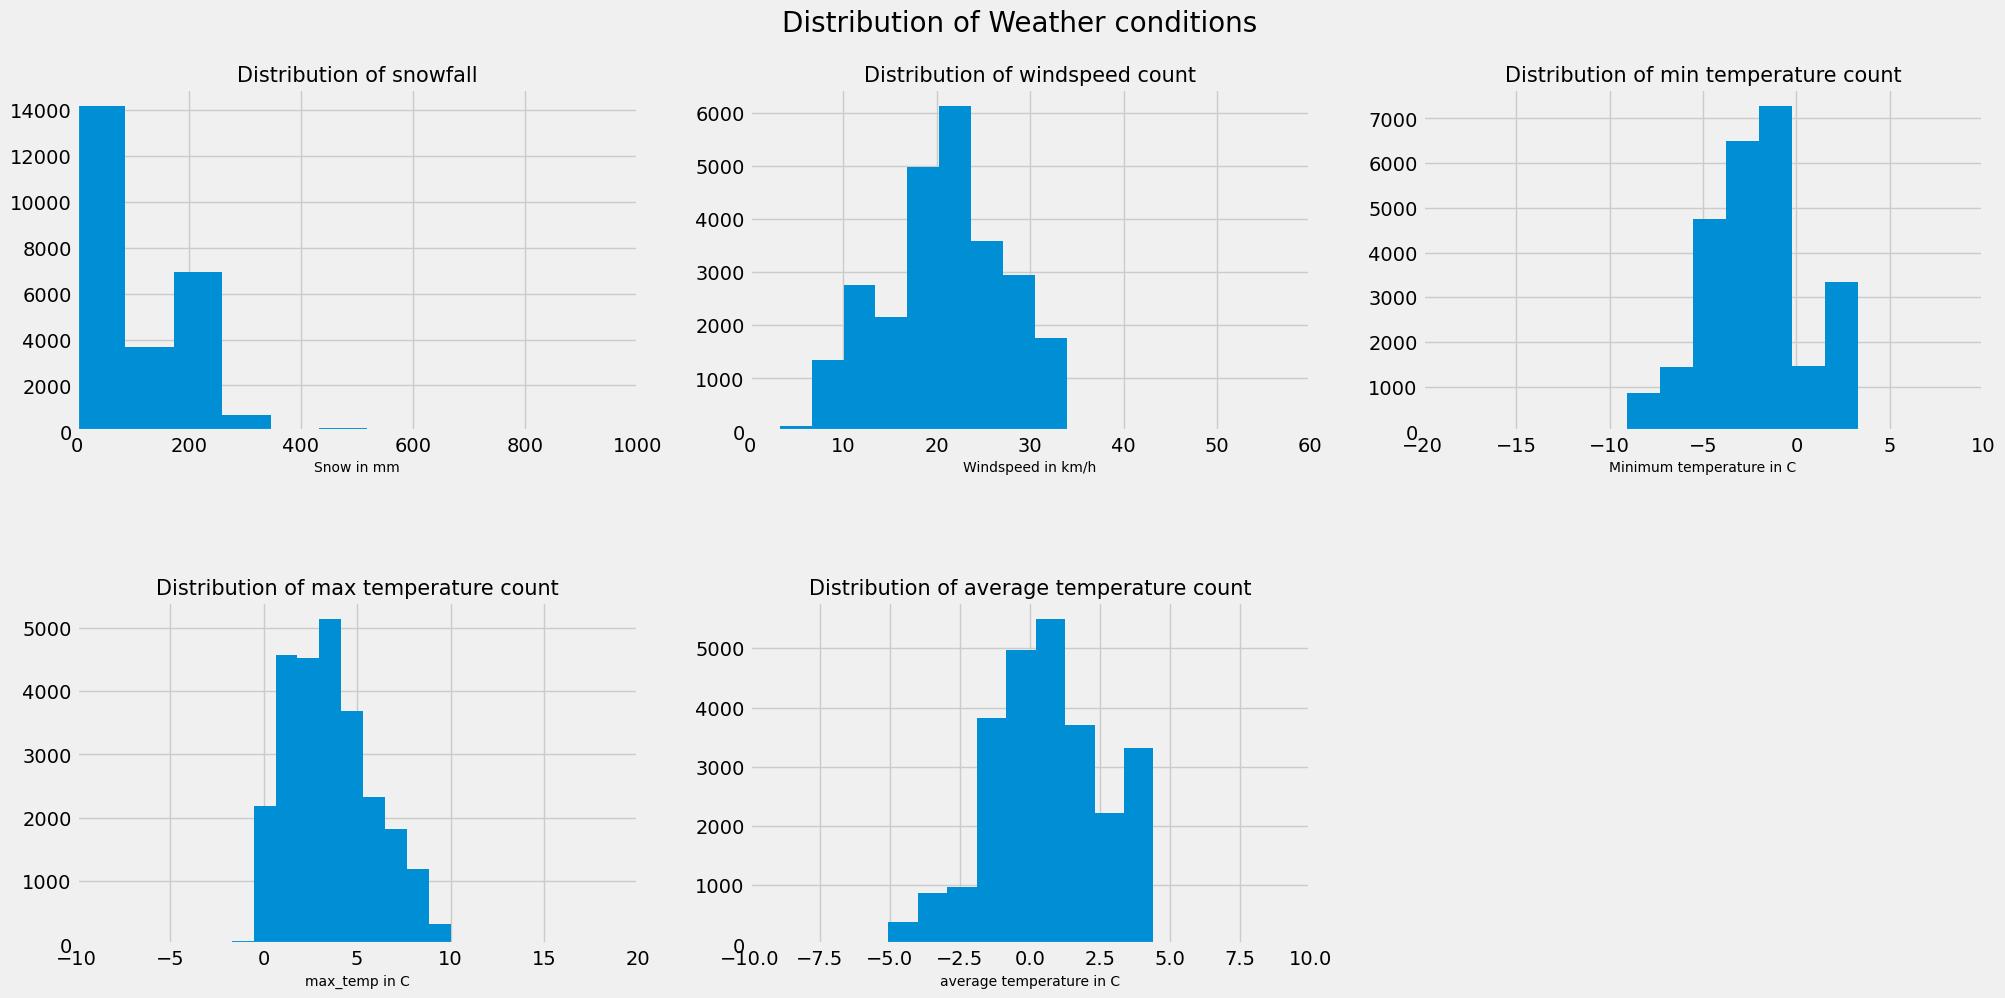

In [39]:
fig, ax = plt.subplots(2,3, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of Weather conditions', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

ax[0][0].hist(x=weather_flights_x_sf['snow'], bins=10)  # creates histogram for number of views
ax[0][0].set_xlabel("Snow in mm", fontsize = 10) # sets the label y-axis
ax[0][0].set_xlim(0,1000) # limits the x-axis values from 0 to 1000000 
ax[0][0].set_title("Distribution of snowfall", fontsize = 15);  # sets title for subplot

ax[0][1].hist(x= weather_flights_x_sf['windspeed'], bins=10)
ax[0][1].set_xlabel("Windspeed in km/h", fontsize = 10)
ax[0][1].set_xlim(0,60)
ax[0][1].set_title("Distribution of windspeed count", fontsize = 15);

ax[0][2].hist(x=weather_flights_x_sf['min_temp'], bins=10)
ax[0][2].set_xlabel("Minimum temperature in C", fontsize = 10)
ax[0][2].set_xlim(-20, 10)
ax[0][2].set_title("Distribution of min temperature count", fontsize = 15);

ax[1][0].hist(x=weather_flights_x_sf['max_temp'], bins=10)
ax[1][0].set_xlabel("max_temp in C", fontsize = 10)
ax[1][0].set_xlim(-10, 20)
ax[1][0].set_title("Distribution of max temperature count", fontsize = 15);
                              
ax[1][1].hist(x=weather_flights_x_sf['average_temp'], bins=10)
ax[1][1].set_xlabel("average temperature in C", fontsize = 10)
ax[1][1].set_xlim(-10,10)
ax[1][1].set_title("Distribution of average temperature count", fontsize = 15);

fig.delaxes(ax[1][2]);


In [162]:
# sorting dates in right order
weather_flights_x_sf_sorted = weather_flights_x_sf.sort_values(by='flight_date') 

In [170]:
# adapting date range
weather_flights_x_sf_sorted = weather_flights_x_sf_sorted[(weather_flights_x_sf_sorted['flight_date'] >= '2010-02-01') &
                                                          (weather_flights_x_sf_sorted['flight_date'] <= '2010-02-21')]

<Figure size 1000x600 with 0 Axes>

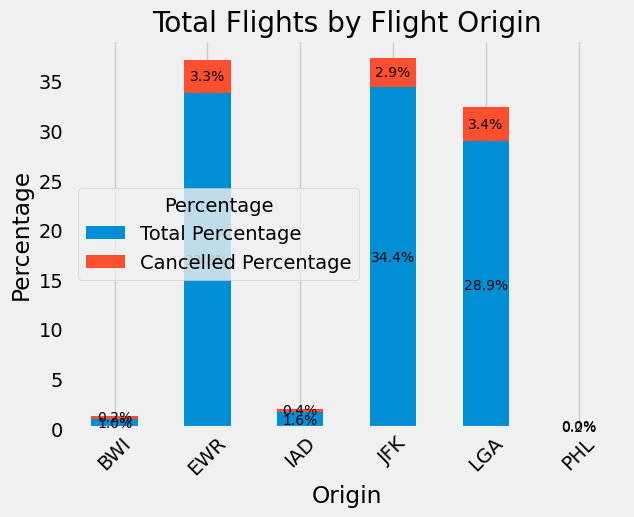

In [177]:
import matplotlib.pyplot as plt

# Calculate total counts of flights by origin
total_counts_per_origin = weather_flights_x_sf_sorted['origin'].value_counts()

# Calculate counts of cancelled flights by origin
cancelled_counts_per_origin = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['cancelled'] == 1]['origin'].value_counts()

# Calculate percentages
total_percentages = total_counts_per_origin / total_counts_per_origin.sum() * 100
cancelled_percentages = cancelled_counts_per_origin / total_counts_per_origin.sum() * 100

# Create DataFrame for plotting
percentages_df = pd.DataFrame({'Total Percentage': total_percentages, 'Cancelled Percentage': cancelled_percentages})

# Plotting
plt.figure(figsize=(10, 6))
ax = percentages_df.plot(kind='bar', stacked=True)

# Annotate each bar with the corresponding percentage
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10)

plt.xlabel('Origin')
plt.ylabel('Percentage')
plt.title('Total Flights by Flight Origin')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Percentage')
plt.show()


In [173]:
cancelled_percentages

EWR   4.53
LGA   4.15
JFK   3.38
IAD   0.36
BWI   0.24
PHL   0.05
Name: origin, dtype: float64

In [180]:
cancelled_counts_per_origin = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['cancelled'] == 1]['origin_2'].value_counts()
cancelled_counts_per_origin

LGA    659
EWR    635
JFK    556
IAD     72
BWI     46
PHL      9
Name: origin_2, dtype: int64

In [212]:
weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['cancelled'] == 0]['origin'].value_counts()

JFK    6065
EWR    5867
LGA    4904
IAD     238
BWI     141
PHL      33
Name: origin, dtype: int64

In [213]:
weather_flights_x_sf_sorted['origin'].value_counts()

JFK    6621
EWR    6502
LGA    5563
IAD     310
BWI     187
PHL      42
Name: origin, dtype: int64

## Checking if the variable 'cancelled' provides all the desired output (origins and destinations)

In [220]:
# Assuming 'cancelled', 'origin', and 'dest' columns specify the cancellation status, origin, and destination respectively

# Create a boolean variable 'cancelled_all' indicating if flight was canceled at origin or destination
weather_flights_x_sf_sorted['cancelled_all'] = (weather_flights_x_sf_sorted['cancelled'] == 1) | (weather_flights_x_sf_sorted['origin'] == 'cancelled') | (weather_flights_x_sf_sorted['dest'] == 'cancelled')

# Display the DataFrame with the new variable
print(weather_flights_x_sf_sorted[['cancelled', 'origin', 'dest', 'cancelled_all']])


       cancelled origin dest  cancelled_all
28453          0    EWR  RSW          False
13040          0    EWR  SEA          False
7917           0    LGA  TYS          False
7958           0    JFK  LAX          False
8014           0    JFK  LAX          False
...          ...    ...  ...            ...
23203          0    EWR  IAH          False
23354          0    EWR  AUS          False
2356           0    EWR  ORD          False
23193          0    EWR  BOS          False
2358           0    EWR  IND          False

[19225 rows x 4 columns]


In [221]:
weather_flights_x_sf_sorted.cancelled_all.value_counts()

False    17248
True      1977
Name: cancelled_all, dtype: int64

In [ ]:
#Cancelled_all and cancelled do not seem to differ regarding the output

In [255]:
# Assuming 'flight_date' column specifies the date of the flight

# Filter the DataFrame for flights on February 10th
flights_feb_10 = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['flight_date'] == '2010-02-10']

# Calculate the number of canceled flights per origin for February 10th
cancelled_counts_per_origin = flights_feb_10[flights_feb_10['cancelled_all'] == 1]['origin'].value_counts()

# Display the result


cancelled_percentages_2 = cancelled_counts_per_origin / total_counts_per_origin.sum() * 100
print(cancelled_percentages_2)

EWR   1.63
JFK   1.43
LGA   1.31
IAD   0.08
BWI   0.05
PHL   0.01
Name: origin, dtype: float64


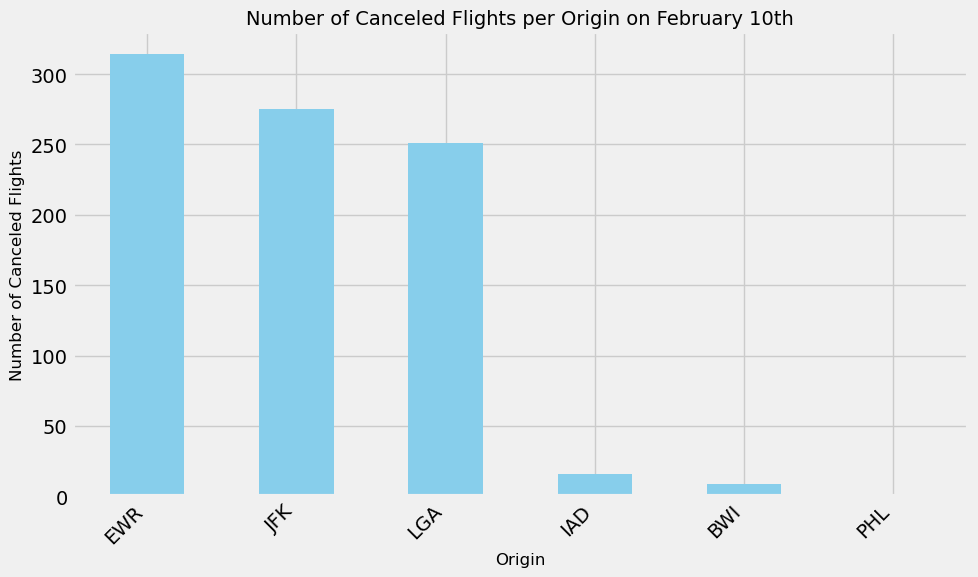

In [223]:
import matplotlib.pyplot as plt

# Assuming 'flight_date' column specifies the date of the flight

# Filter the DataFrame for flights on February 10th
flights_feb_10 = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['flight_date'] == '2010-02-10']

# Calculate the number of canceled flights per origin for February 10th
cancelled_counts_per_origin = flights_feb_10[flights_feb_10['cancelled_all'] == 1]['origin'].value_counts()

# Plot the number of canceled flights per origin
cancelled_counts_per_origin.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Set the title and labels
plt.title('Number of Canceled Flights per Origin on February 10th', fontsize=14)
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Number of Canceled Flights', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



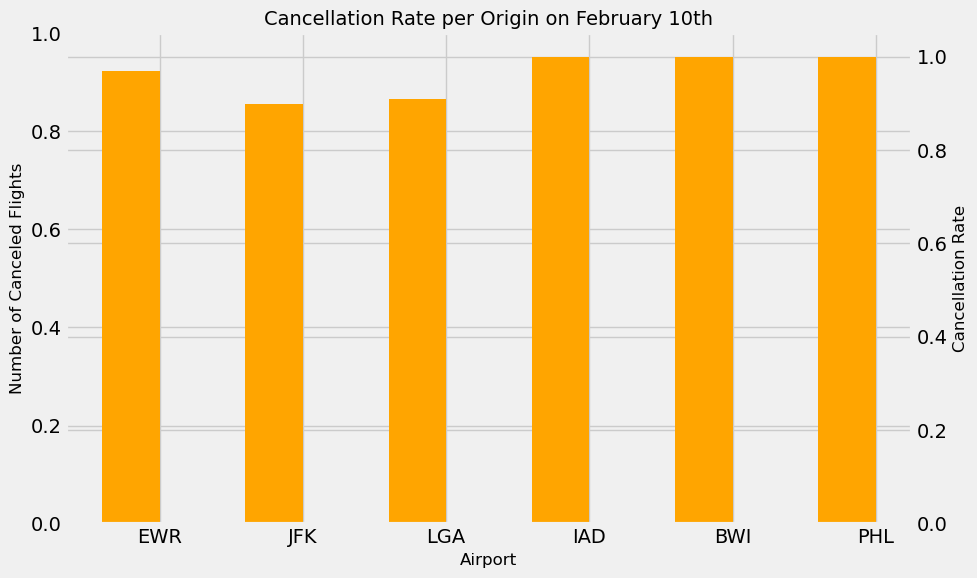

In [227]:
import matplotlib.pyplot as plt

# Assuming 'flight_date' column specifies the date of the flight

# Filter the DataFrame for flights on February 10th
flights_feb_10 = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['flight_date'] == '2010-02-10']

# Calculate the total number of flights per origin for February 10th
total_flights_per_origin = flights_feb_10['origin'].value_counts()

# Calculate the number of canceled flights per origin for February 10th
#cancelled_counts_per_origin = flights_feb_10[flights_feb_10['cancelled'] == 1]['origin'].value_counts()

# Calculate the cancellation rate per origin for February 10th
cancellation_rate_per_origin = cancelled_counts_per_origin / total_flights_per_origin

# Plot the number of canceled flights and cancellation rate per origin
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot number of canceled flights
#cancelled_counts_per_origin.plot(kind='bar', color='skyblue', ax=ax1, position=0, width=0.4, label='Canceled Flights')

# Create a secondary y-axis for cancellation rate
ax2 = ax1.twinx()
cancellation_rate_per_origin.plot(kind='bar', color='orange', ax=ax2, position=1, width=0.4, label='Cancellation Rate')

# Set the title and labels
plt.title('Cancellation Rate per Airport on February 10th', fontsize=14)
ax1.set_xlabel('Airport', fontsize=12)
ax1.set_ylabel('Number of Canceled Flights', fontsize=12)
ax2.set_ylabel('Cancellation Rate', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
#fig.legend(loc="upper left")
plt.tight_layout()
plt.show()



In [189]:
snowfall_bwi_mean = weather_flights_x_sf_sorted.loc[weather_flights_x_sf_sorted['origin'] == 'BWI', 'snow'].mean()
print("Mean snowfall for flights originating from 'BWI':", snowfall_bwi_mean)


Mean snowfall for flights originating from 'BWI': 364.0267379679144


In [190]:
snowfall_bwi_mean = weather_flights_x_sf_sorted.loc[weather_flights_x_sf_sorted['origin'] == 'BWI', 'snow'].max()
print("Mean snowfall for flights originating from 'BWI':", snowfall_bwi_mean)


Mean snowfall for flights originating from 'BWI': 864.0


In [229]:
max_snowfall_all_origins = weather_flights_x_sf_sorted.groupby('origin')['snow'].max()
print("Maximum snowfall for all origins:")
print(max_snowfall_all_origins)


Maximum snowfall for all origins:
origin
BWI   864.00
EWR   279.00
IAD   660.00
JFK   254.00
LGA   254.00
PHL   508.00
Name: snow, dtype: float64


In [228]:
max_snowfall_all_origins = weather_flights_x_sf_sorted.groupby('origin')['snow'].mean()
print("Maximum snowfall for all airports:")
print(max_snowfall_all_origins)


Maximum snowfall for all airports:
origin
BWI   364.03
EWR    90.49
IAD   327.97
JFK   103.15
LGA    80.05
PHL   234.67
Name: snow, dtype: float64


In [147]:
max_snowfall_all_origins_by_date = weather_flights_x_sf_sorted.groupby(['flight_date', 'origin'])['snow'].max().reset_index()
print("Maximum snowfall for all origins by flight date:")
max_snowfall_all_origins_by_date


Maximum snowfall for all origins by flight date:


,flight_date,origin,snow
0,2010-02-01,BWI,102.00
1,2010-02-01,EWR,0.00
2,2010-02-01,IAD,51.00
3,2010-02-01,JFK,0.00
4,2010-02-01,LGA,0.00
...,...,...,...
121,2010-02-21,EWR,0.00
122,2010-02-21,IAD,127.00
123,2010-02-21,JFK,51.00
124,2010-02-21,LGA,0.00


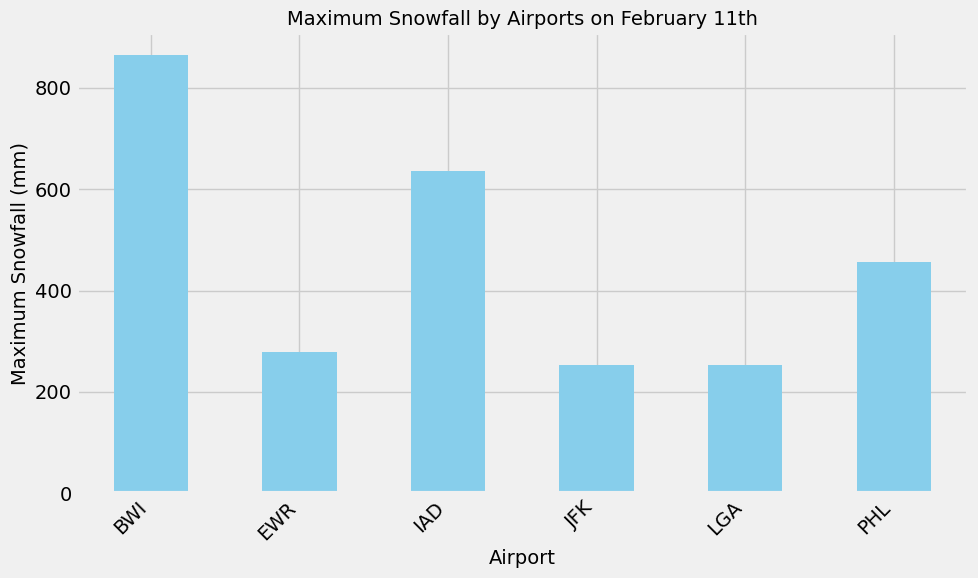

In [236]:
import matplotlib.pyplot as plt

# Assuming 'flight_date', 'origin', and 'snow' columns specify the date of the flight, origin airport, and snowfall respectively

# Filter the DataFrame for flights on February 11th
flights_feb_11 = weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['flight_date'] == '2010-02-11']

# Calculate the maximum snowfall for all origins
max_snowfall_all_origins = flights_feb_11.groupby('origin')['snow'].max()

# Plot the maximum snowfall for all origins
max_snowfall_all_origins.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Set the title and labels
plt.title('Maximum Snowfall by Airports on February 11th', fontsize=14)
plt.xlabel('Airport', fontsize=14)
plt.ylabel('Maximum Snowfall (mm)', fontsize=14)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [248]:
# Assuming 'origin' and 'snow' columns specify the origin airport and snowfall respectively

# Calculate the mean snowfall for each origin
mean_snowfall_per_origin = weather_flights_x_sf_sorted.groupby('origin')['snow'].mean()

# Display the result
print(mean_snowfall_per_origin)


origin
BWI   364.03
EWR    90.49
IAD   327.97
JFK   103.15
LGA    80.05
PHL   234.67
Name: snow, dtype: float64


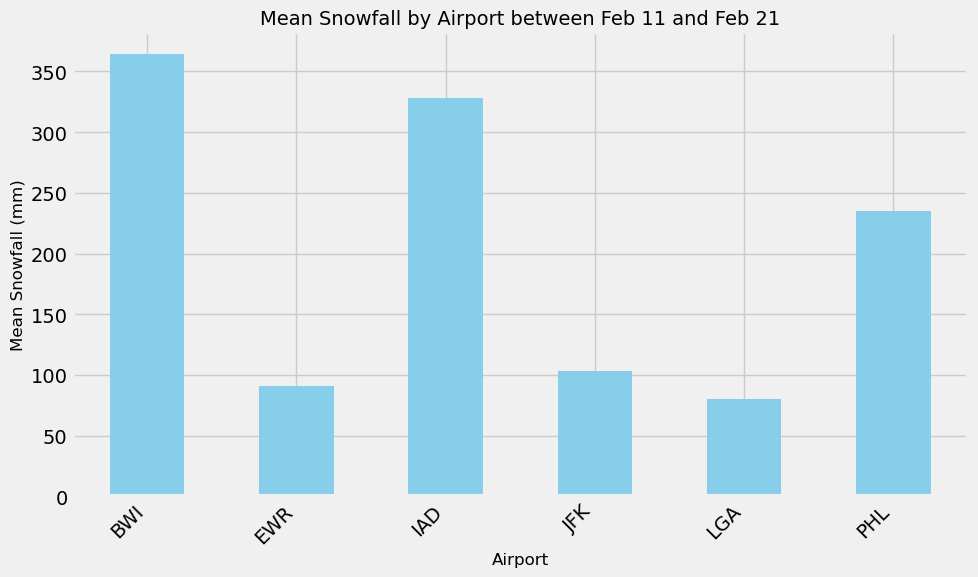

In [251]:
import matplotlib.pyplot as plt

# Plot the mean snowfall for each origin
mean_snowfall_per_origin.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Set the title and labels
plt.title('Mean Snowfall by Airport between Feb 11 and Feb 21', fontsize=14)
plt.xlabel('Airport', fontsize=12)
plt.ylabel('Mean Snowfall (mm)', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


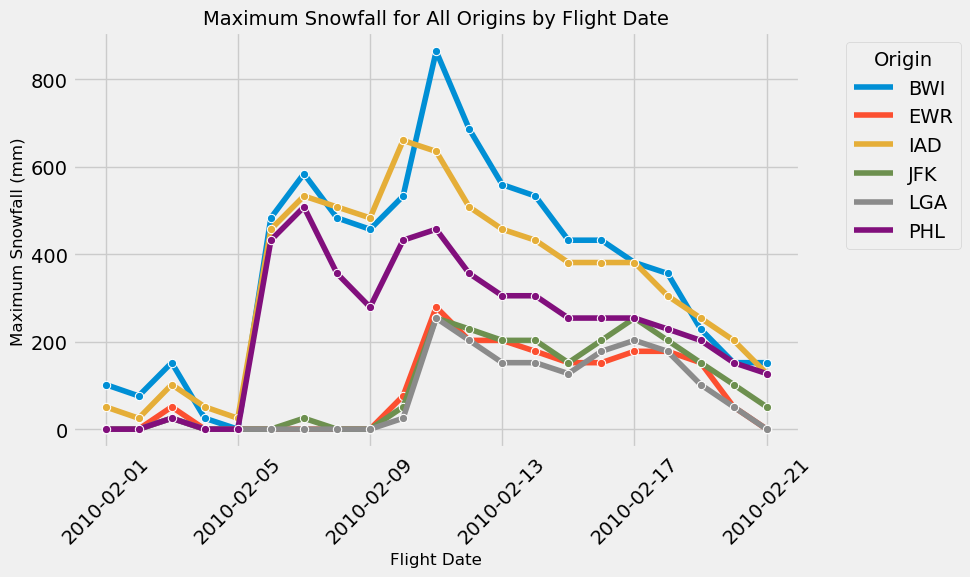

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by flight date and origin, and calculate the maximum snowfall for each combination
max_snowfall_all_origins_by_date = weather_flights_x_sf_sorted.groupby(['flight_date', 'origin'])['snow'].max().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=max_snowfall_all_origins_by_date, x='flight_date', y='snow', hue='origin', marker='o')

# Set title and labels
plt.title('Maximum Snowfall for All Origins by Flight Date', fontsize=14)
plt.xlabel('Flight Date', fontsize=12)
plt.ylabel('Maximum Snowfall (mm)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='Origin', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


## checking distributions of snow and flight cancellation

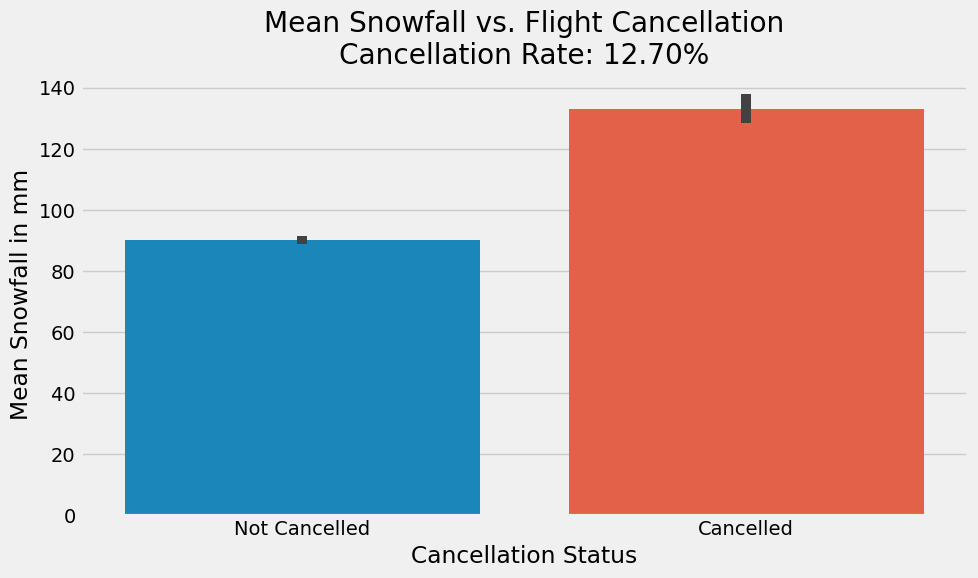

In [50]:
# Convert 'cancelled' column to string representation
weather_flights_x_sf_sorted['cancelled_str'] = weather_flights_x_sf_sorted['cancelled'].astype(str)

# Calculate cancellation rate
cancellation_rate = (weather_flights_x_sf_sorted['cancelled'] == 1).mean() * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cancelled_str', y='snow', data=weather_flights_x_sf_sorted, estimator='mean')

plt.title(f'Mean Snowfall vs. Flight Cancellation\nCancellation Rate: {cancellation_rate:.2f}%')
plt.xlabel('Cancellation Status')
plt.ylabel('Mean Snowfall in mm')
plt.xticks(ticks=[0, 1], labels=['Not Cancelled', 'Cancelled'])
plt.tight_layout()
plt.show()


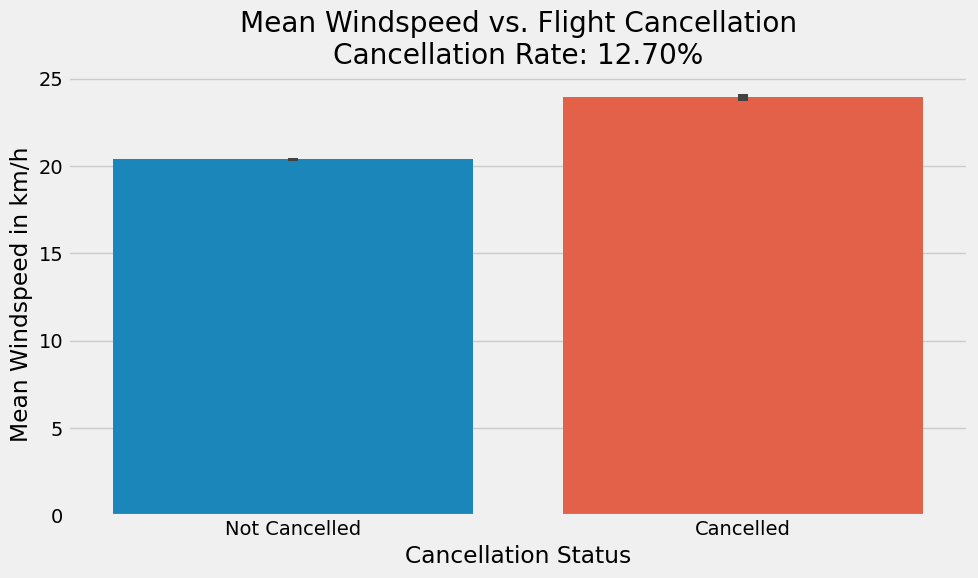

In [51]:
cancellation_rate = (weather_flights_x_sf_sorted['cancelled'] == 1).mean() * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cancelled_str', y='windspeed', data=weather_flights_x_sf_sorted, estimator='mean')

plt.title(f'Mean Windspeed vs. Flight Cancellation\nCancellation Rate: {cancellation_rate:.2f}%')
plt.xlabel('Cancellation Status')
plt.ylabel('Mean Windspeed in km/h')
plt.xticks(ticks=[0, 1], labels=['Not Cancelled', 'Cancelled'])
plt.tight_layout()
plt.show()

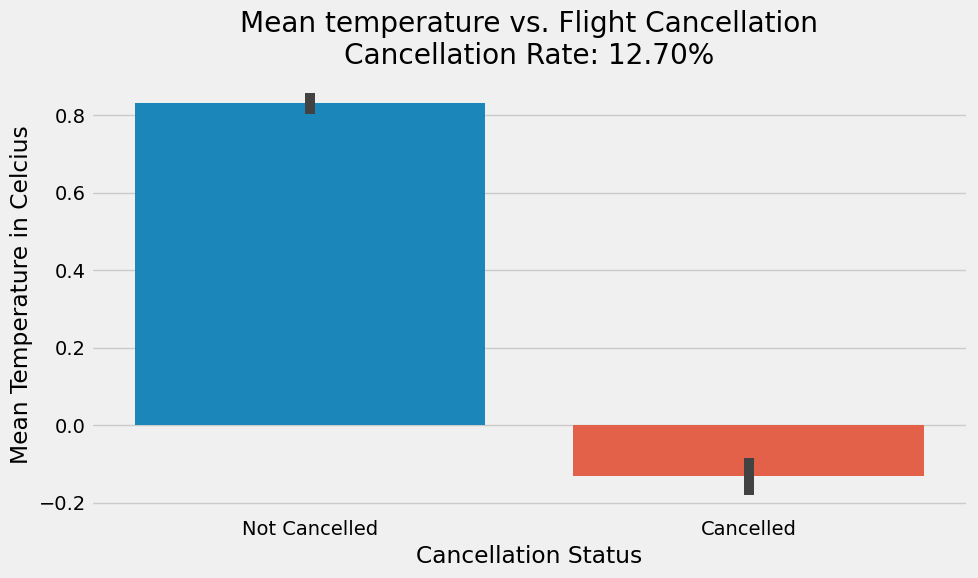

In [52]:
# Convert 'cancelled' column to string representation
weather_flights_x_sf_sorted['cancelled_str'] = weather_flights_x_sf_sorted['cancelled'].astype(str)

# Calculate cancellation rate
cancellation_rate = (weather_flights_x_sf_sorted['cancelled'] == 1).mean() * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cancelled_str', y='average_temp', data=weather_flights_x_sf_sorted, estimator='mean')

plt.title(f'Mean temperature vs. Flight Cancellation\nCancellation Rate: {cancellation_rate:.2f}%')
plt.xlabel('Cancellation Status')
plt.ylabel('Mean Temperature in Celcius')
plt.xticks(ticks=[0, 1], labels=['Not Cancelled', 'Cancelled'])
plt.tight_layout()
plt.show()

## Bivariate correlations coefficients

In [161]:
import scipy.stats as stats

# Calculate point-biserial correlation coefficient for each numerical variable
for col in ['snow', 'windspeed', 'average_temp']:
    correlation_coefficient, p_value = stats.pointbiserialr(weather_flights_with_cancellation['cancelled'], weather_flights_with_cancellation[col])
    print(f"Point-biserial correlation coefficient between 'cancelled' and '{col}': {correlation_coefficient}")
    print(f"P-value: {p_value}\n")

Point-biserial correlation coefficient between 'cancelled' and 'snow': 0.06127613326416549
P-value: 1.837450858747195e-17

Point-biserial correlation coefficient between 'cancelled' and 'windspeed': 0.20327749377483129
P-value: 1.9965971333714349e-178

Point-biserial correlation coefficient between 'cancelled' and 'average_temp': -0.11681337174015954
P-value: 2.18756151342922e-59



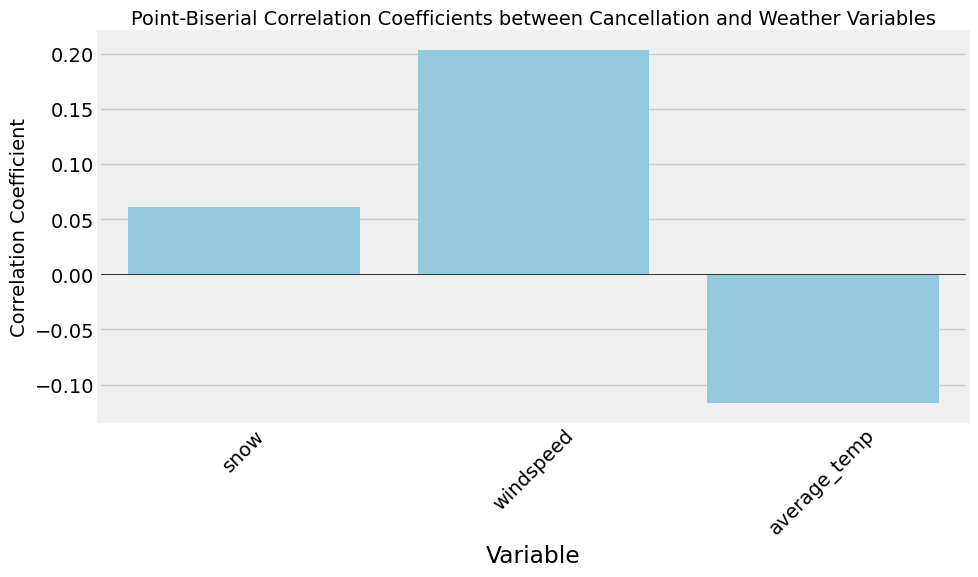

In [238]:

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate point-biserial correlation coefficient for each numerical variable
correlation_data = []
for col in ["snow", "windspeed", "average_temp"]:
    correlation_coefficient, p_value = stats.pointbiserialr(weather_flights_x_sf_sorted['cancelled'], weather_flights_x_sf_sorted[col])
    correlation_data.append({'Variable': col, 'Correlation Coefficient': correlation_coefficient, 'P-value': p_value})

# Convert correlation data to DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Create a bar plot with requested adjustments
plt.figure(figsize=(10, 6), facecolor='white')  # Set facecolor to white
sns.barplot(data=correlation_df, x='Variable', y='Correlation Coefficient', color='skyblue')
plt.title('Point-Biserial Correlation Coefficients between Cancellation and Weather Variables', fontsize=14, color='black')
plt.ylabel('Correlation Coefficient', fontsize=14, color='black')
#plt.xlabel('Weather Variable', fontsize=10, color='black')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0 for reference
plt.tight_layout()
plt.show()


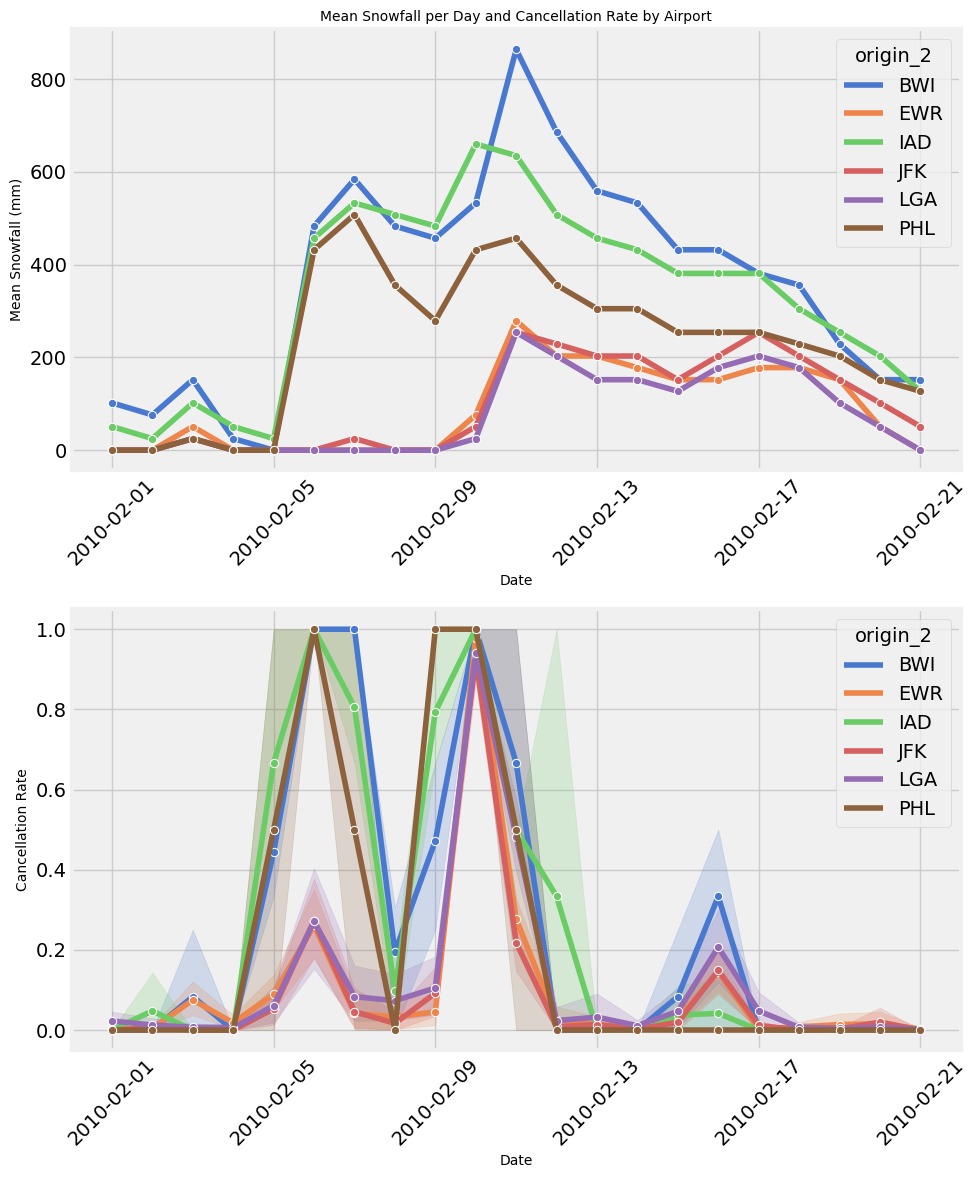

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

weather_flights_x_sf_sorted = weather_flights_x_sf_sorted[(weather_flights_x_sf_sorted['flight_date'] >= '2010-02-01') &
                                                          (weather_flights_x_sf_sorted['flight_date'] <= '2010-02-21')]

# Group by flight date and origin, and calculate the mean snowfall and cancellation rate
mean_snowfall_per_day = weather_flights_x_sf_sorted.groupby(['flight_date', 'origin_2', 'dest'])['snow'].mean().reset_index()
cancellation_rate_per_day = weather_flights_x_sf_sorted.groupby(['flight_date', 'origin_2', 'dest'])['cancelled'].mean().reset_index()

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12), facecolor='white')  # Set facecolor to white

# Plot mean snowfall per day
sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='snow', hue='origin_2', marker='o', palette='muted', ax=ax[0])
ax[0].set_title('Mean Snowfall per Day and Cancellation Rate by Airport', fontsize=10, color='black')
ax[0].set_ylabel('Mean Snowfall (mm)', fontsize=10, color='black')
ax[0].set_xlabel('Date', fontsize=10, color='black')
ax[0].grid(True)

# Rotate x-axis labels for mean snowfall plot
ax[0].tick_params(axis='x', rotation=45)

# Plot cancellation rate per day
sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', hue='origin_2', marker='o', palette='muted', ax=ax[1])
ax[1].set_xlabel('Date', fontsize=10, color='black')
ax[1].set_ylabel('Cancellation Rate', fontsize=10, color='black')
ax[1].grid(True)

# Rotate x-axis labels for cancellation rate plot
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/vv/4d0yjm893_xcqs8y21lfl70c0000gn/T/ipykernel_14600/4237562653.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='snow', marker='o', palette='muted', ax=ax[0])
/var/folders/vv/4d0yjm893_xcqs8y21lfl70c0000gn/T/ipykernel_14600/4237562653.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', marker='o', palette='muted', ax=ax[1])


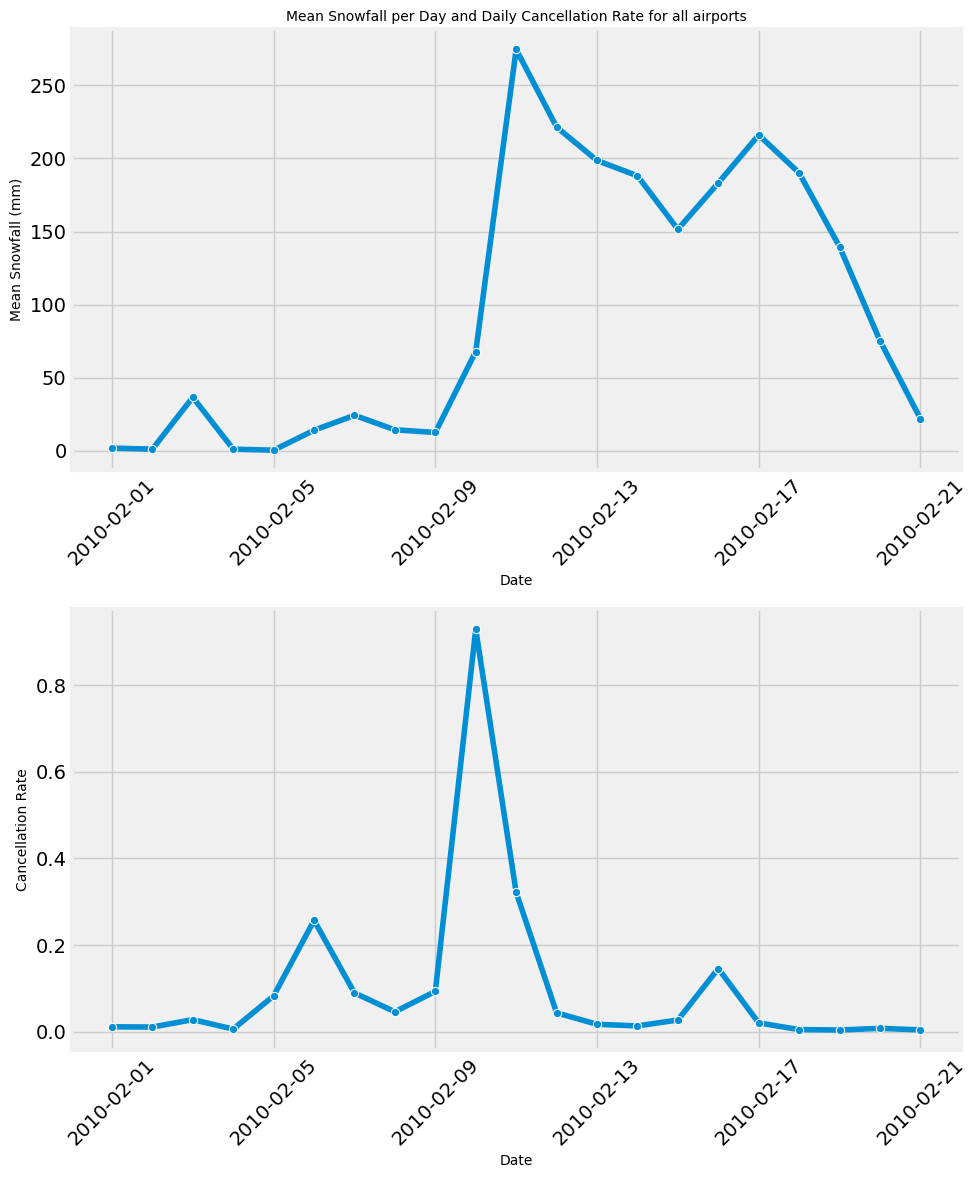

In [254]:
# Filter the DataFrame for flights between February 1st and February 21st
weather_flights_x_sf_sorted = weather_flights_x_sf_sorted[(weather_flights_x_sf_sorted['flight_date'] >= '2010-02-01') & (weather_flights_x_sf_sorted['flight_date'] <= '2010-02-21')]

# Group by flight date and origin, and calculate the mean snowfall and cancellation rate per day
mean_snowfall_per_day = weather_flights_x_sf_sorted.groupby('flight_date')['snow'].mean().reset_index()
cancellation_rate_per_day = weather_flights_x_sf_sorted.groupby('flight_date')['cancelled'].mean().reset_index()

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12), facecolor='white')  # Set facecolor to white

# Plot mean snowfall per day
sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='snow', marker='o', palette='muted', ax=ax[0])
ax[0].set_title('Mean Snowfall per Day and Daily Cancellation Rate for all airports', fontsize=10, color='black')
ax[0].set_ylabel('Mean Snowfall (mm)', fontsize=10, color='black')
ax[0].set_xlabel('Date', fontsize=10, color='black')
ax[0].grid(True)

# Rotate x-axis labels for mean snowfall plot
ax[0].tick_params(axis='x', rotation=45)

# Plot cancellation rate per day
sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', marker='o', palette='muted', ax=ax[1])
ax[1].set_xlabel('Date', fontsize=10, color='black')
ax[1].set_ylabel('Cancellation Rate', fontsize=10, color='black')
ax[1].grid(True)

# Rotate x-axis labels for cancellation rate plot
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/vv/4d0yjm893_xcqs8y21lfl70c0000gn/T/ipykernel_14600/4152272700.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='windspeed', marker='o', palette='muted', ax=ax[0])
/var/folders/vv/4d0yjm893_xcqs8y21lfl70c0000gn/T/ipykernel_14600/4152272700.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', marker='o', palette='muted', ax=ax[1])


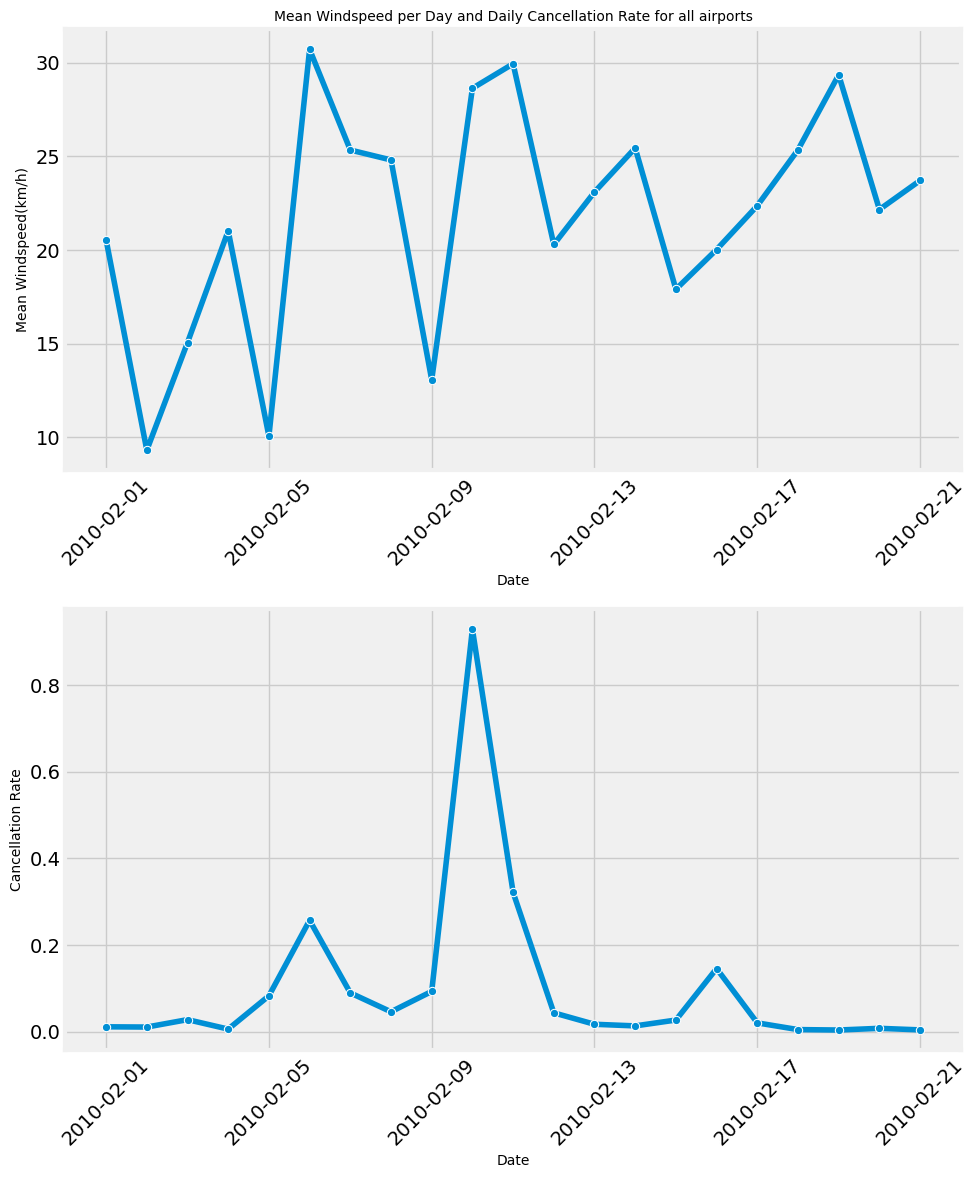

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns

weather_flights_x_sf_sorted = weather_flights_x_sf_sorted[(weather_flights_x_sf_sorted['flight_date'] >= '2010-02-01') &
                                                          (weather_flights_x_sf_sorted['flight_date'] <= '2010-02-21')]

# Group by flight date and origin, and calculate the mean snowfall and cancellation rate
mean_snowfall_per_day = weather_flights_x_sf_sorted.groupby(['flight_date'])['windspeed'].mean().reset_index()
cancellation_rate_per_day = weather_flights_x_sf_sorted.groupby(['flight_date'])['cancelled'].mean().reset_index()

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12), facecolor='white')  # Set facecolor to white

# Plot mean snowfall per day
sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='windspeed', marker='o', palette='muted', ax=ax[0])
ax[0].set_title('Mean Windspeed per Day and Daily Cancellation Rate for all airports', fontsize=10, color='black')
ax[0].set_ylabel('Mean Windspeed(km/h)', fontsize=10, color='black')
ax[0].set_xlabel('Date', fontsize=10, color='black')
ax[0].grid(True)

# Rotate x-axis labels for mean snowfall plot
ax[0].tick_params(axis='x', rotation=45)

# Plot cancellation rate per day
sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', marker='o', palette='muted', ax=ax[1])
ax[1].set_xlabel('Date', fontsize=10, color='black')
ax[1].set_ylabel('Cancellation Rate', fontsize=10, color='black')
ax[1].grid(True)

# Rotate x-axis labels for cancellation rate plot
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


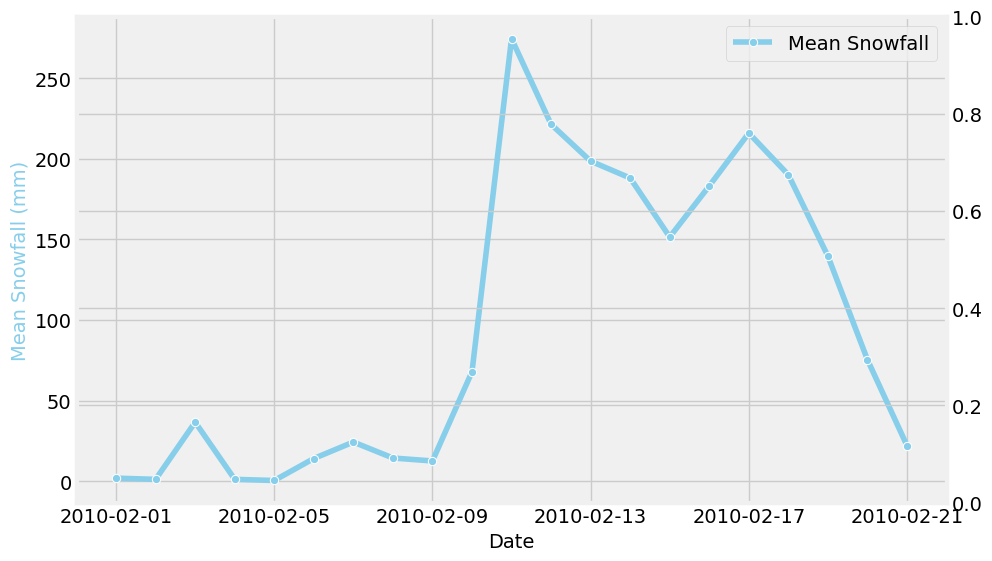

<Figure size 640x480 with 0 Axes>

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming weather_flights_x_sf_sorted contains filtered data and calculations for the specified date range

# Group by flight date and origin, and calculate the mean snowfall and cancellation rate
mean_snowfall_per_day = weather_flights_x_sf_sorted.groupby('flight_date')['snow'].mean().reset_index()

# Calculate the proportion of cancelled flights for each day
cancellation_rate_per_day = weather_flights_x_sf_sorted.groupby('flight_date')['cancelled'].mean().reset_index()

# Create a figure with one subplot

fig, ax1 = plt.subplots(figsize=(10, 6), facecolor='white')

# Plot mean snowfall per day on the first y-axis
g=sns.lineplot(data=mean_snowfall_per_day, x='flight_date', y='snow', marker='o', color='skyblue', label='Mean Snowfall', ax=ax1)
ax1.set_ylabel('Mean Snowfall (mm)', fontsize=14, color='skyblue')
ax1.set_xlabel('Date', fontsize=14, color='black')


# Create a second y-axis for cancellation rate
ax2 = ax1.twinx()
#sns.lineplot(data=cancellation_rate_per_day, x='flight_date', y='cancelled', marker='o', color='orange', label='Cancellation Rate', ax=ax2)
#ax2.set_ylabel('Cancellation Rate', fontsize=14, color='orange')

plt.show()
# Rotate x-axis labels

ax[0].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## percentage of cancellations due to snow?

In [244]:
# Assuming 'cancelled', 'snow', and 'flight_date' columns specify the cancellation status, snowfall amount, and date of the flight respectively

# Calculate the total number of canceled flights
total_canceled_flights = len(weather_flights_x_sf_sorted[weather_flights_x_sf_sorted['cancelled'] == 1])

# Calculate the total number of flights
total_flights = len(weather_flights_x_sf_sorted)

# Calculate the total number of canceled flights where snowfall amount is not zero
snow_attribution_flights = len(weather_flights_x_sf_sorted[(weather_flights_x_sf_sorted['cancelled'] == 1) & (weather_flights_x_sf_sorted['snow'] > 0)])

# Calculate the percentage of flight cancellations attributable to snow
snow_attribution_percentage = (snow_attribution_flights / total_canceled_flights) * 100

print("Percentage of flight cancellations attributable to snow:", snow_attribution_percentage)


Percentage of flight cancellations attributable to snow: 79.61557916034396
